In [5]:
import os
import pandas as pd
import re

base_path = 'dense_data'
data = []

def extract_index(filename):
    """Extrae el número del archivo, por ejemplo 'frame_0159.png' -> '0159'"""
    match = re.search(r'(\d+)', filename)
    return match.group(1) if match else None

for level_name in os.listdir(base_path):
    level_path = os.path.join(base_path, level_name)
    if not os.path.isdir(level_path):
        continue

    frame_path = os.path.join(level_path, 'frame')
    combined_path = os.path.join(level_path, 'combined')

    frames = {}
    combineds = {}

    # Leer frames
    if os.path.isdir(frame_path):
        for fname in os.listdir(frame_path):
            index = extract_index(fname)
            if index:
                frames[index] = fname

    # Leer combined visuals
    if os.path.isdir(combined_path):
        for cname in os.listdir(combined_path):
            index = extract_index(cname)
            if index:
                combineds[index] = cname

    # Buscar coincidencias exactas por índice
    for index in sorted(set(frames.keys()) & set(combineds.keys())):
        data.append({
            "name": level_name,
            "frame": frames[index],
            "combined": combineds[index]
        })

# Crear DataFrame final
df = pd.DataFrame(data)
print(df)


                      name           frame                combined
0     gran_paradiso_island  frame_0000.png  mask_combined_0000.png
1     gran_paradiso_island  frame_0001.png  mask_combined_0001.png
2     gran_paradiso_island  frame_0002.png  mask_combined_0002.png
3     gran_paradiso_island  frame_0003.png  mask_combined_0003.png
4     gran_paradiso_island  frame_0004.png  mask_combined_0004.png
...                    ...             ...                     ...
1495            lighthouse  frame_0245.png  mask_combined_0245.png
1496            lighthouse  frame_0246.png  mask_combined_0246.png
1497            lighthouse  frame_0247.png  mask_combined_0247.png
1498            lighthouse  frame_0248.png  mask_combined_0248.png
1499            lighthouse  frame_0249.png  mask_combined_0249.png

[1500 rows x 3 columns]


In [3]:
# Mostrar las filas donde el valor de 'frame' es None
print(df[df["combined"].isnull()])

Empty DataFrame
Columns: [name, frame, combined]
Index: []


In [15]:
import os
import pandas as pd

# Filas con valores nulos en la columna "combined"
null_rows = df[df["combined"].isnull()]

# Borrar los archivos correspondientes
for _,filepath in null_rows.iterrows():
    mask_path = f"./{base_path}/{filepath['name']}/frame/{filepath['frame']}"
    
    try:
        os.remove(mask_path)
        print(f"Borrado: {mask_path}")
    except Exception as e:
        print(f"Error al borrar {mask_path}: {e}")
    

Borrado: ./dense_data/hacienda/frame/frame_0130.png
Borrado: ./dense_data/hacienda/frame/frame_0167.png
Borrado: ./dense_data/hacienda/frame/frame_0447.png
Borrado: ./dense_data/hacienda/frame/frame_0483.png
Borrado: ./dense_data/hacienda/frame/frame_0172.png
Borrado: ./dense_data/hacienda/frame/frame_0253.png
Borrado: ./dense_data/hacienda/frame/frame_0298.png
Borrado: ./dense_data/hacienda/frame/frame_0105.png
Borrado: ./dense_data/hacienda/frame/frame_0112.png
Borrado: ./dense_data/hacienda/frame/frame_0020.png
Borrado: ./dense_data/hacienda/frame/frame_0469.png
Borrado: ./dense_data/hacienda/frame/frame_0243.png
Borrado: ./dense_data/hacienda/frame/frame_0343.png
Borrado: ./dense_data/hacienda/frame/frame_0127.png
Borrado: ./dense_data/hacienda/frame/frame_0398.png
Borrado: ./dense_data/hacienda/frame/frame_0481.png
Borrado: ./dense_data/hacienda/frame/frame_0059.png
Borrado: ./dense_data/hacienda/frame/frame_0351.png
Borrado: ./dense_data/hacienda/frame/frame_0493.png
Borrado: ./d

In [121]:
#### separacion de valores
from sklearn.model_selection import train_test_split
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
df_train, df_test = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df["name"],
)
df_train, df_val = train_test_split(
    df_train,
    test_size=0.25,
    random_state=42,
    stratify=df_train["name"],
)
number=125
img_prueba_frame = cv2.imread(f"{base_path}/{df['name'].iloc[number]}/frame/{df['frame'].iloc[number]}")
img_prueba_mask = cv2.imread(f"{base_path}/{df['name'].iloc[number]}/combined/{df['combined'].iloc[number]}")

print(
    f"""
Muestras en train: {len(df_train)}
Muestras en val: {len(df_val)}
Muestras en test: {len(df_test)}
Dimesiones imagen Frame: {img_prueba_frame.shape}
Dimesiones imagen mask: {img_prueba_mask.shape}
"""
)

np.savetxt("mask_3.txt", img_prueba_mask.transpose(2,0,1)[1], fmt="%d")


Muestras en train: 956
Muestras en val: 319
Muestras en test: 225
Dimesiones imagen Frame: (400, 400, 3)
Dimesiones imagen mask: (400, 400, 3)



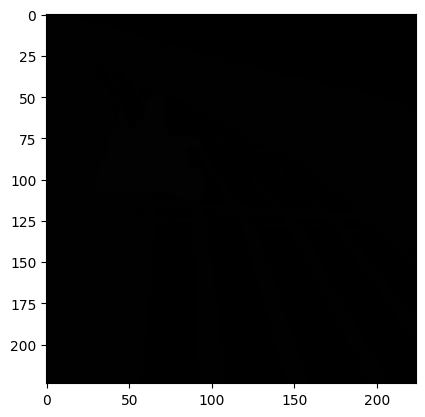

In [ ]:
from torchvision.transforms import v2
import torch
AUMENTATION_TRANSFORM = v2.Compose(
    [

        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.RandomHorizontalFlip(p=0.6),
        v2.RandomRotation(45),
    ]
)

MASK_TRANSFORM = v2.Compose([
    v2.Resize(size=(256, 256)),
    v2.CenterCrop(size=(224, 224)),
    v2.ToDtype(torch.int64)
])
img_prueba_frame,img_prueba_mask=v2.ToImage()(img_prueba_frame,img_prueba_mask)

img_frame,img_mask=MASK_TRANSFORM(img_prueba_frame,img_prueba_mask)
img_frame,img_mask=AUMENTATION_TRANSFORM(img_frame,img_mask)
plt.figure()
plt.imshow(img_mask.permute(1, 2, 0).numpy(),cmap="gray")
plt.show()


In [4]:
from models import UNet, TransferSegmentation, save_model, load_model
import torch 
import torch.nn as nn 
from torchvision.transforms import v2 
from utils import load_data
import torch.utils.tensorboard as tb 
import numpy as np

torch.manual_seed(17)
### cambiar #### 
def calculate_multiclass_iou(predicted_logits, target_mask, num_classes, epsilon=1e-6):
    """
    Calcula el IoU por clase y el IoU medio (mIoU) para segmentación multiclase.

    Args:
        predicted_logits: Tensor de tamaño [B, C, H, W] (salida del modelo sin softmax)
        target_mask: Tensor de tamaño [B, H, W] con valores de clase enteros
        num_classes: número total de clases
    """
    # Obtener predicción final por clase (argmax en el canal de clases)
    predicted_mask = torch.argmax(predicted_logits, dim=1)  # [B, H, W]

    ious = []
    for cls in range(num_classes):
        pred_cls = (predicted_mask == cls)
        target_cls = (target_mask == cls)

        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()

        iou = (intersection + epsilon) / (union + epsilon)
        ious.append(iou)

    mean_iou = torch.mean(torch.tensor(ious))
    return predicted_mask, mean_iou.item()


In [5]:
import datetime 

train_logger = None 
log_dir = f'semantic_segmentation/runs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}' 

if log_dir:
    from os import path 
    train_logger = tb.SummaryWriter(path.join(log_dir), 'train', flush_secs=1)

In [ ]:
model = TransferSegmentation(n_classes=7)
transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224))
])
#transform = model.weights.transforms() # resulta mejor con la transformacion propia
#Cambiar utils
train_loader = load_data(df_train, transform=transform, batch_size=128)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

criterion = nn.CrossEntropyLoss() # aplica sigmoid directamente sobre los logits del m1odelo
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max')

cuda


In [ ]:
# Training Loop
best_iou = 0
num_epochs = 100
i = 0
patience = 10
max_patience = 15

for epoch in range(num_epochs):
    running_loss = 0
    epoch_mean_iou = []

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        
        targets = targets.long().squeeze().to(device)
        outputs = model(inputs)
        #print(targets.shape)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs, batch_iou = calculate_multiclass_iou(outputs, targets, 7)
        epoch_mean_iou.append(batch_iou)

        running_loss += loss.item()
        ## Corregir para escala de grises y dimencion faltante
        targets = targets.unsqueeze(1)
        targets=targets*32
        targets=targets.float()/255
        outputs = outputs.unsqueeze(1)
        outputs=outputs*32
        outputs=outputs.float()/255


        if log_dir is not None:
            train_logger.add_images("image", inputs[:6], i)
            train_logger.add_images("label", targets[:6], i)  # Add channel dimension
            train_logger.add_images("pred", outputs[:6], i)

            if i == 0:
                train_logger.add_graph(
                    model, inputs
                )  # representacion grafica del modelo
            i += 1

    # Epoch Estadisticas
    epoch_mean_iou = np.mean(epoch_mean_iou) * 100
    epoch_loss = running_loss / len(train_loader)

    scheduler.step(epoch_mean_iou)

    if log_dir is not None:
        train_logger.add_scalar("epoch_mean_iou", epoch_mean_iou, epoch)
        train_logger.add_scalar("epoch_loss", epoch_loss, epoch)
        train_logger.add_scalar("epoch_lr", optimizer.param_groups[0]["lr"], epoch)

    print(
        f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.2f} Mean IoU: {epoch_mean_iou:.2f}%"
    )

    if epoch_mean_iou > best_iou:
        best_iou = epoch_mean_iou
        save_model(model, "TransferSegmentation.th")
        patience = 0
    else:
        patience += 1

    if patience == max_patience:
        break